# Gaussian Processes vs Kernel Ridge Regression

Analysis code for the portfolio performance dataset.

We use:
- **Inputs**: weights of the stock-picking concepts (6 features).
- **Target**: normalized annual return ("all period" sheet).

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from scipy.linalg import cholesky, solve_triangular
from scipy.optimize import minimize

## RBF kernel

In [2]:
def rbf_kernel(X1, X2, lengthscale, variance):
    """
    Squared exponential / RBF kernel.

    k(x, x') = variance * exp( - 0.5 * ||x - x'||^2 / lengthscale^2 )

    Parameters
    ----------
    X1 : array, shape (n1, D)
    X2 : array, shape (n2, D)
    lengthscale : float > 0
    variance : float > 0   (this is sigma_f^2 in R&W)

    Returns
    -------
    K : array, shape (n1, n2)
        Kernel matrix.
    """
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    # Squared Euclidean distance matrix
    sqdist = (
        np.sum(X1**2, axis=1)[:, None]
        + np.sum(X2**2, axis=1)[None, :]
        - 2.0 * X1.dot(X2.T)
    )
    return variance * np.exp(-0.5 * sqdist / (lengthscale ** 2))

## Gaussian Process regression (zero mean, RBF kernel, Gaussian noise)

In [3]:
def gp_neg_log_marginal_likelihood(theta_log, X, y):
    """
    Negative log marginal likelihood for GP regression with RBF kernel.

    theta_log = [log(ell), log(sigma_f), log(sigma_n)]
    """
    ell, sigma_f, sigma_n = np.exp(theta_log)

    K = rbf_kernel(X, X, ell, sigma_f ** 2)
    Ky = K + sigma_n ** 2 * np.eye(X.shape[0])

    try:
        L = cholesky(Ky, lower=True, check_finite=False)
    except np.linalg.LinAlgError:
        # Numerical issue -> huge penalty
        return 1e10

    alpha = solve_triangular(
        L.T,
        solve_triangular(L, y, lower=True, check_finite=False),
        lower=False,
        check_finite=False,
    )

    log_det = 2.0 * np.sum(np.log(np.diag(L)))
    n = X.shape[0]
    nll = 0.5 * y.dot(alpha) + 0.5 * log_det + 0.5 * n * np.log(2.0 * np.pi)
    return nll


def gp_fit_marginal_likelihood(X, y, initial_log_theta=None, bounds=None):
    """
    Fit GP hyperparameters by minimizing the negative log marginal likelihood.

    Returns a dict with ell, sigma_f, sigma_n and the full optimizer result.
    """
    if initial_log_theta is None:
        y_std = np.std(y)
        if y_std == 0:
            y_std = 1.0
        initial = np.log([1.0, y_std, 0.1 * y_std])  # heuristic
    else:
        initial = np.asarray(initial_log_theta)

    if bounds is None:
        # log-params in [log(1e-3), log(1e3)]
        bounds = [(-7, 7), (-7, 7), (-7, 7)]

    res = minimize(
        gp_neg_log_marginal_likelihood,
        initial,
        args=(X, y),
        method="L-BFGS-B",
        bounds=bounds,
    )

    ell, sigma_f, sigma_n = np.exp(res.x)
    return {"ell": ell, "sigma_f": sigma_f, "sigma_n": sigma_n, "opt_result": res}


def gp_predict(X_train, y_train, X_test, ell, sigma_f, sigma_n, return_var=True):
    """
    GP posterior predictive at X_test.

    Returns
    -------
    mean : (n_test,)
    var  : (n_test,)  (if return_var=True)
    """
    K = rbf_kernel(X_train, X_train, ell, sigma_f ** 2)
    Ky = K + sigma_n ** 2 * np.eye(X_train.shape[0])

    L = cholesky(Ky, lower=True, check_finite=False)
    alpha = solve_triangular(
        L.T,
        solve_triangular(L, y_train, lower=True, check_finite=False),
        lower=False,
        check_finite=False,
    )

    K_star = rbf_kernel(X_train, X_test, ell, sigma_f ** 2)
    mean = K_star.T.dot(alpha)

    if not return_var:
        return mean

    v = solve_triangular(L, K_star, lower=True, check_finite=False)
    K_starstar = rbf_kernel(X_test, X_test, ell, sigma_f ** 2)
    cov = K_starstar - v.T.dot(v)
    var = np.clip(np.diag(cov), 0.0, np.inf)  # numeric safety

    return mean, var

def gaussian_nlpd(y_true, y_mean, y_var, min_var=1e-9):
    """Pointwise NLPD for y ~ N(y_mean, y_var). Returns array."""
    y_true = np.asarray(y_true).ravel()
    y_mean = np.asarray(y_mean).ravel()
    y_var  = np.asarray(y_var).ravel()
    y_var = np.maximum(y_var, min_var)
    return 0.5 * np.log(2.0 * np.pi * y_var) + 0.5 * (y_true - y_mean) ** 2 / y_var

def gp_cross_validation(
    X, y,
    ell_grid, sigma_f_grid, sigma_n_grid,
    n_splits=5, random_state=0,
    objective="nlpd",
    verbose=False,
):
    """
    Grid-search K-fold CV for GP regression hyperparameters (RBF kernel).

    Evaluates BOTH:
      - CV MSE on predictive mean
      - CV NLPD on predictive density p(y_val | x_val, D_train, theta)

    Predictive density for noisy targets:
        y_* | D, x_* ~ N(mu_f(x_*), Var[f_*(x_*)|D] + sigma_n^2)

    objective: "nlpd" (default) or "mse" determines which metric selects the best hyperparameters.

    Returns
    -------
    best_params : dict
    best_cv_mse : float
    best_cv_nlpd : float
    cv_results : pd.DataFrame
        One row per grid point with columns:
        [ell, sigma_f, sigma_n, cv_mse, cv_nlpd]
        Sorted by the chosen objective.
    """
    if objective not in {"nlpd", "mse"}:
        raise ValueError("objective must be either 'nlpd' or 'mse'.")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best_score = np.inf
    best_params = None
    best_cv_mse = np.inf
    best_cv_nlpd = np.inf

    rows = []

    for ell in ell_grid:
        for sigma_f in sigma_f_grid:
            for sigma_n in sigma_n_grid:

                fold_mse = []
                fold_nlpd = []

                for train_idx, val_idx in kf.split(X):
                    X_tr, X_val = X[train_idx], X[val_idx]
                    y_tr, y_val = y[train_idx], y[val_idx]

                    mu_val, var_f_val = gp_predict(
                        X_tr, y_tr, X_val,
                        ell, sigma_f, sigma_n,
                        return_var=True,
                    )

                    # (1) MSE on predictive mean
                    fold_mse.append(mean_squared_error(y_val, mu_val))

                    # (2) NLPD on predictive density for y (includes noise variance)
                    var_y_val = var_f_val + sigma_n ** 2
                    fold_nlpd.append(float(np.mean(gaussian_nlpd(y_val, mu_val, var_y_val))))

                mean_mse = float(np.mean(fold_mse))
                mean_nlpd = float(np.mean(fold_nlpd))

                rows.append(
                    {
                        "ell": float(ell),
                        "sigma_f": float(sigma_f),
                        "sigma_n": float(sigma_n),
                        "cv_mse": mean_mse,
                        "cv_nlpd": mean_nlpd,
                    }
                )

                score = mean_nlpd if objective == "nlpd" else mean_mse
                if score < best_score:
                    best_score = score
                    best_cv_mse = mean_mse
                    best_cv_nlpd = mean_nlpd
                    best_params = {"ell": float(ell), "sigma_f": float(sigma_f), "sigma_n": float(sigma_n)}

                if verbose:
                    print(
                        f"[GP-CV] ell={ell:.3g}, sigma_f={sigma_f:.3g}, sigma_n={sigma_n:.3g} "
                        f"-> CV MSE={mean_mse:.4e}, CV NLPD={mean_nlpd:.4e}"
                    )

    cv_results = pd.DataFrame(rows)
    sort_key = "cv_nlpd" if objective == "nlpd" else "cv_mse"
    cv_results = cv_results.sort_values(sort_key, ascending=True).reset_index(drop=True)

    return best_params, best_cv_mse, best_cv_nlpd, cv_results


## Kernel Ridge Regression

In [4]:
def krr_fit(X, y, lambd, ell, sigma_f):
    """
    Kernel ridge regression with RBF kernel.

    Objective:
        (1/(2n)) * ||y - f||^2 + (lambda / 2) * ||f||^2_{H_k}

    Solution:
        alpha = (K + lambda * n * I)^{-1} y

    Returns a model dict.
    """
    n = X.shape[0]
    K = rbf_kernel(X, X, ell, sigma_f ** 2)
    A = K + lambd * n * np.eye(n)
    alpha = np.linalg.solve(A, y)
    return {
        "alpha": alpha,
        "X_train": X.copy(),
        "ell": ell,
        "sigma_f": sigma_f,
        "lambd": lambd,
    }


def krr_predict(model, X_test):
    """Predict with KRR model."""
    K_star = rbf_kernel(
        model["X_train"], X_test,
        model["ell"], model["sigma_f"] ** 2
    )
    y_pred = K_star.T.dot(model["alpha"])
    return y_pred


def krr_cross_validation(X, y, lambd_grid, ell_grid, sigma_f_grid,
                         n_splits=5, random_state=0, verbose=False):
    """
    Grid-search K-fold CV for KRR hyperparameters (lambda, ell, sigma_f).
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    best_params = None
    best_mse = np.inf

    for lambd in lambd_grid:
        for ell in ell_grid:
            for sigma_f in sigma_f_grid:
                mse_folds = []
                for train_idx, val_idx in kf.split(X):
                    X_tr, X_val = X[train_idx], X[val_idx]
                    y_tr, y_val = y[train_idx], y[val_idx]

                    model = krr_fit(X_tr, y_tr, lambd, ell, sigma_f)
                    y_pred = krr_predict(model, X_val)
                    mse_folds.append(mean_squared_error(y_val, y_pred))

                mse_cv = float(np.mean(mse_folds))
                if verbose:
                    print(
                        f"KRR-CV lambda={lambd:.3g}, ell={ell:.3g}, "
                        f"sigma_f={sigma_f:.3g}, CV MSE={mse_cv:.4g}"
                    )

                if mse_cv < best_mse:
                    best_mse = mse_cv
                    best_params = {"lambd": lambd, "ell": ell, "sigma_f": sigma_f}

    return best_params, best_mse

## Data loading: portfolio dataset (`all period` sheet)

In [5]:
def load_portfolio_dataset_all_period(path):
    """
    Load 'all period' sheet and build:
      X = weights of stock-picking concepts (n x 6)
      y = normalized annual return (n,)

    Columns are taken directly from the Excel multi-index header.
    """
    xls = pd.ExcelFile(path)
    df = pd.read_excel(xls, sheet_name="all period", header=[0, 1])

    # Input columns: the weight of the stock-picking concept
    weight_cols = [
        col for col in df.columns
        if col[0].startswith("the weight")
    ]

    # Target column: normalized annual return
    target_col = (
        'the normalized  investment performance indicator',
        'Annual Return',
    )

    df_sub = df[weight_cols + [target_col]].dropna()
    X = df_sub[weight_cols].to_numpy(dtype=float)
    y = df_sub[target_col].to_numpy(dtype=float)

    return X, y

## Full experiment: GP-ML, GP-CV, KRR-CV

In [6]:
def run_experiment_with_gp_and_krr(path, test_size=0.3, random_state=0):
    # ----- Load data -----
    X, y = load_portfolio_dataset_all_period(path)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Standardize X and y (common in GP practice)
    X_scaler = StandardScaler().fit(X_train)
    X_train_s = X_scaler.transform(X_train)
    X_test_s = X_scaler.transform(X_test)

    y_mean = float(np.mean(y_train))
    y_std = float(np.std(y_train))
    if y_std == 0:
        y_std = 1.0
    y_train_s = (y_train - y_mean) / y_std

    print("Training points:", X_train_s.shape[0], " Test points:", X_test_s.shape[0])

    # ===========================
    # 1) GP with marginal likelihood
    # ===========================
    print("\nFitting GP (RBF kernel) by marginal likelihood...")
    gp_ml_params = gp_fit_marginal_likelihood(X_train_s, y_train_s)
    print("GP-ML hyperparameters (scaled space):")
    print(gp_ml_params)

    gp_ml_mean_s, gp_ml_var_f_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=True,
    )
    gp_ml_mean = y_mean + y_std * gp_ml_mean_s
    gp_ml_var_y = (gp_ml_var_f_s + gp_ml_params["sigma_n"] ** 2) * (y_std ** 2)

    gp_ml_mse = mean_squared_error(y_test, gp_ml_mean)
    gp_ml_nlpd = float(np.mean(gaussian_nlpd(y_test, gp_ml_mean, gp_ml_var_y)))

    print(f"GP-ML test MSE:  {gp_ml_mse:.6f}")
    print(f"GP-ML mean NLPD: {gp_ml_nlpd:.6f}")

    # ===========================
    # 2) GP hyperparameters via cross-validation
    # ===========================
    print("\nTuning GP hyperparameters by cross-validation (grid search)...")
    ell_grid = np.linspace(2, 4, 30)
    sigma_f_grid = np.linspace(1.2, 2, 30)
    sigma_n_grid = np.logspace(-2, -1, 30)

    # We run the SAME CV grid, but select hyperparameters using:
    #   (i)  NLPD (probabilistic calibration)
    #   (ii) MSE  (point prediction accuracy)
    gp_cv_nlpd_best, gp_cv_nlpd_cv_mse, gp_cv_nlpd_cv_nlpd, gp_cv_nlpd_cv_results = gp_cross_validation(
        X_train_s, y_train_s,
        ell_grid, sigma_f_grid, sigma_n_grid,
        n_splits=5, random_state=random_state, objective="nlpd", verbose=False,
    )
    gp_cv_mse_best, gp_cv_mse_cv_mse, gp_cv_mse_cv_nlpd, gp_cv_mse_cv_results = gp_cross_validation(
        X_train_s, y_train_s,
        ell_grid, sigma_f_grid, sigma_n_grid,
        n_splits=5, random_state=random_state, objective="mse", verbose=False,
    )

    print("\nBest GP-CV hyperparameters (select by NLPD, scaled space):")
    print(gp_cv_nlpd_best)
    print(f"  CV NLPD (scaled y): {gp_cv_nlpd_cv_nlpd:.6f}")
    print(f"  CV MSE  (scaled y): {gp_cv_nlpd_cv_mse:.6f}")

    print("\nBest GP-CV hyperparameters (select by MSE, scaled space):")
    print(gp_cv_mse_best)
    print(f"  CV MSE  (scaled y): {gp_cv_mse_cv_mse:.6f}")
    print(f"  CV NLPD (scaled y): {gp_cv_mse_cv_nlpd:.6f}")

    def _evaluate_gp_on_test(params, label):
        """Evaluate GP predictive mean and NLPD on the (unscaled) test set."""
        mean_s, var_f_s = gp_predict(
            X_train_s, y_train_s, X_test_s,
            params["ell"], params["sigma_f"], params["sigma_n"],
            return_var=True,
        )
        mean = y_mean + y_std * mean_s
        var_y = (var_f_s + params["sigma_n"] ** 2) * (y_std ** 2)

        mse = mean_squared_error(y_test, mean)
        nlpd = float(np.mean(gaussian_nlpd(y_test, mean, var_y)))

        print(f"{label} test MSE:  {mse:.6f}")
        print(f"{label} mean NLPD: {nlpd:.6f}")
        return {"mse": float(mse), "nlpd": float(nlpd)}

    gp_cv_nlpd_eval = _evaluate_gp_on_test(gp_cv_nlpd_best, "GP-CV (select NLPD)")
    gp_cv_mse_eval  = _evaluate_gp_on_test(gp_cv_mse_best,  "GP-CV (select MSE)")

    # ===========================
    # 3) Kernel ridge regression via CV
    # ===========================
    print("\nTuning Kernel Ridge Regression by cross-validation...")
    lambd_grid = np.logspace(-4.5, -3.5, 30)
    ell_grid_krr = np.linspace(2, 4, 30)
    sigma_f_grid_krr = np.linspace(1.2, 2, 30)

    krr_best, krr_best_mse_cv = krr_cross_validation(
        X_train_s, y_train_s,
        lambd_grid, ell_grid_krr, sigma_f_grid_krr,
        n_splits=5, random_state=random_state, verbose=False,
    )
    print("Best KRR hyperparameters (scaled space):")
    print(krr_best)
    print(f"Best KRR CV MSE (scaled y): {krr_best_mse_cv:.6f}")

    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s = krr_predict(krr_model, X_test_s)
    krr_pred = y_mean + y_std * krr_pred_s
    krr_mse = float(mean_squared_error(y_test, krr_pred))
    print(f"KRR test MSE: {krr_mse:.6f}")

    # ===========================
    # 4) Direct comparison GP mean vs KRR prediction
    # ===========================
    gp_ml_mean_s_only = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=False,
    )
    diff = gp_ml_mean_s_only - krr_pred_s
    print("\nDifference between GP-ML mean and KRR prediction (scaled y):")
    print(f"  Mean |diff|: {np.mean(np.abs(diff)):.4e}")
    print(f"  Max  |diff|: {np.max(np.abs(diff)):.4e}")

    # ===========================
    # 5) Summary table of results (includes BOTH GP-CV variants)
    # ===========================
    summary = pd.DataFrame(
        {
            "Test MSE": [
                gp_ml_mse,
                gp_cv_nlpd_eval["mse"],
                gp_cv_mse_eval["mse"],
                krr_mse,
            ],
            "Mean NLPD": [
                gp_ml_nlpd,
                gp_cv_nlpd_eval["nlpd"],
                gp_cv_mse_eval["nlpd"],
                np.nan,  # not defined for deterministic KRR
            ],
            "CV MSE (scaled y)": [
                np.nan,
                gp_cv_nlpd_cv_mse,
                gp_cv_mse_cv_mse,
                krr_best_mse_cv,
            ],
            "CV NLPD (scaled y)": [
                np.nan,
                gp_cv_nlpd_cv_nlpd,
                gp_cv_mse_cv_nlpd,
                np.nan,
            ],
            "ell": [
                gp_ml_params["ell"],
                gp_cv_nlpd_best["ell"],
                gp_cv_mse_best["ell"],
                krr_best["ell"],
            ],
            "sigma_f": [
                gp_ml_params["sigma_f"],
                gp_cv_nlpd_best["sigma_f"],
                gp_cv_mse_best["sigma_f"],
                krr_best["sigma_f"],
            ],
            "sigma_n / lambda": [
                gp_ml_params["sigma_n"],
                gp_cv_nlpd_best["sigma_n"],
                gp_cv_mse_best["sigma_n"],
                krr_best["lambd"],
            ],
        },
        index=["GP-ML", "GP-CV (select NLPD)", "GP-CV (select MSE)", "KRR-CV"],
    )

    print("\n========== Summary of results ==========")
    print(summary)
    print("========================================\n")

    results = {
        # Raw data / splits
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,

        # Scaling (useful for plots)
        "X_scaler": X_scaler,
        "y_mean": y_mean,
        "y_std": y_std,

        # Scaled design matrices/targets
        "X_train_s": X_train_s,
        "X_test_s": X_test_s,
        "y_train_s": y_train_s,

        # GP-ML
        "gp_ml_params": gp_ml_params,
        "gp_ml_test_mse": float(gp_ml_mse),
        "gp_ml_test_nlpd": float(gp_ml_nlpd),

        # GP-CV (select NLPD)
        "gp_cv_nlpd_best": gp_cv_nlpd_best,
        "gp_cv_nlpd_cv_mse": float(gp_cv_nlpd_cv_mse),
        "gp_cv_nlpd_cv_nlpd": float(gp_cv_nlpd_cv_nlpd),
        "gp_cv_nlpd_cv_results": gp_cv_nlpd_cv_results,
        "gp_cv_nlpd_test_mse": float(gp_cv_nlpd_eval["mse"]),
        "gp_cv_nlpd_test_nlpd": float(gp_cv_nlpd_eval["nlpd"]),

        # GP-CV (select MSE)
        "gp_cv_mse_best": gp_cv_mse_best,
        "gp_cv_mse_cv_mse": float(gp_cv_mse_cv_mse),
        "gp_cv_mse_cv_nlpd": float(gp_cv_mse_cv_nlpd),
        "gp_cv_mse_cv_results": gp_cv_mse_cv_results,
        "gp_cv_mse_test_mse": float(gp_cv_mse_eval["mse"]),
        "gp_cv_mse_test_nlpd": float(gp_cv_mse_eval["nlpd"]),

        # KRR-CV
        "krr_best": krr_best,
        "krr_best_mse_cv": float(krr_best_mse_cv),
        "krr_test_mse": float(krr_mse),

        # Summary table
        "summary": summary,
    }
    return results

## Plots

In [7]:
def _get_scalers(results):
    """
    Return (X_scaler, y_mean, y_std). If not stored in `results`,
    recompute from X_train / y_train for backward compatibility.
    """
    if "X_scaler" in results and "y_mean" in results and "y_std" in results:
        return results["X_scaler"], results["y_mean"], results["y_std"]

    X_train = results["X_train"]
    y_train = results["y_train"]
    X_scaler = StandardScaler().fit(X_train)
    y_mean = float(np.mean(y_train))
    y_std = float(np.std(y_train))
    if y_std == 0:
        y_std = 1.0
    return X_scaler, y_mean, y_std


def plot_parity(results, save_path=None):
    """
    Parity plot: y_true vs y_pred for
      - GP-ML
      - GP-CV (select NLPD)
      - GP-CV (select MSE)
      - KRR-CV
    """
    X_scaler, y_mean, y_std = _get_scalers(results)

    X_train_s = results["X_train_s"]
    X_test_s = results["X_test_s"]
    y_train_s = results["y_train_s"]
    y_test = results["y_test"]

    # ----- GP-ML -----
    gp_ml = results["gp_ml_params"]
    gp_ml_mean_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml["ell"], gp_ml["sigma_f"], gp_ml["sigma_n"],
        return_var=False,
    )
    gp_ml_mean = y_mean + y_std * gp_ml_mean_s

    # ----- GP-CV (select NLPD) -----
    gp_cv_nlpd = results["gp_cv_nlpd_best"]
    gp_cv_nlpd_mean_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_cv_nlpd["ell"], gp_cv_nlpd["sigma_f"], gp_cv_nlpd["sigma_n"],
        return_var=False,
    )
    gp_cv_nlpd_mean = y_mean + y_std * gp_cv_nlpd_mean_s

    # ----- GP-CV (select MSE) -----
    gp_cv_mse = results["gp_cv_mse_best"]
    gp_cv_mse_mean_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_cv_mse["ell"], gp_cv_mse["sigma_f"], gp_cv_mse["sigma_n"],
        return_var=False,
    )
    gp_cv_mse_mean = y_mean + y_std * gp_cv_mse_mean_s

    # ----- KRR-CV -----
    krr_best = results["krr_best"]
    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s = krr_predict(krr_model, X_test_s)
    krr_pred = y_mean + y_std * krr_pred_s

    # Common axis limits
    all_vals = np.concatenate(
        [y_test.ravel(),
         gp_ml_mean.ravel(),
         gp_cv_nlpd_mean.ravel(),
         gp_cv_mse_mean.ravel(),
         krr_pred.ravel()]
    )
    global_min = float(np.min(all_vals))
    global_max = float(np.max(all_vals))
    margin = 0.02 * (global_max - global_min + 1e-12)
    global_min -= margin
    global_max += margin

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(y_test, gp_ml_mean, label="GP-ML", alpha=0.8)
    ax.scatter(y_test, gp_cv_nlpd_mean, label="GP-CV (select NLPD)", alpha=0.8)
    ax.scatter(y_test, gp_cv_mse_mean, label="GP-CV (select MSE)", alpha=0.8)
    ax.scatter(y_test, krr_pred, label="KRR-CV", alpha=0.8)

    ax.plot([global_min, global_max], [global_min, global_max], linestyle="--")
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)

    ax.set_xlabel("True y (test)")
    ax.set_ylabel("Predicted y (test)")
    ax.set_title("Parity plot (test set)")
    ax.legend()

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=200)
    plt.show()


def plot_1d_slice(
    results,
    feature_index=0,
    feature_names=None,
    n_points=200,
    save_path=None,
):
    """
    1D slice along one input dimension:

    - Fix all but one feature at the mean (in standardized space).
    - Vary one feature across the observed training range.
    - Plot:
        * GP-ML mean ± 2 std (latent f uncertainty)
        * GP-CV (select NLPD) mean
        * GP-CV (select MSE) mean
        * KRR-CV mean
      plus training points.

    Notes
    -----
    The uncertainty band is for the latent function f(x), not for y (it excludes sigma_n^2).
    """
    X_scaler, y_mean, y_std = _get_scalers(results)

    X_train = results["X_train"]
    y_train = results["y_train"]

    X_train_s = results["X_train_s"]
    y_train_s = results["y_train_s"]

    # Base point: mean of standardized X
    x0_s = X_train_s.mean(axis=0)
    f = int(feature_index)

    f_min = float(X_train_s[:, f].min())
    f_max = float(X_train_s[:, f].max())
    grid_f = np.linspace(f_min, f_max, n_points)

    X_grid_s = np.tile(x0_s, (n_points, 1))
    X_grid_s[:, f] = grid_f

    # Back to original scale for x-axis
    X_grid = X_scaler.inverse_transform(X_grid_s)
    x_axis = X_grid[:, f]

    # ----- GP-ML on grid -----
    gp_ml = results["gp_ml_params"]
    gp_ml_mean_s_grid, gp_ml_var_f_s_grid = gp_predict(
        X_train_s, y_train_s, X_grid_s,
        gp_ml["ell"], gp_ml["sigma_f"], gp_ml["sigma_n"],
        return_var=True,
    )
    gp_ml_mean_grid = y_mean + y_std * gp_ml_mean_s_grid
    gp_ml_std_grid = np.sqrt(np.maximum(gp_ml_var_f_s_grid, 0.0)) * y_std

    # ----- GP-CV (select NLPD) on grid -----
    gp_cv_nlpd = results["gp_cv_nlpd_best"]
    gp_cv_nlpd_mean_s_grid = gp_predict(
        X_train_s, y_train_s, X_grid_s,
        gp_cv_nlpd["ell"], gp_cv_nlpd["sigma_f"], gp_cv_nlpd["sigma_n"],
        return_var=False,
    )
    gp_cv_nlpd_mean_grid = y_mean + y_std * gp_cv_nlpd_mean_s_grid

    # ----- GP-CV (select MSE) on grid -----
    gp_cv_mse = results["gp_cv_mse_best"]
    gp_cv_mse_mean_s_grid = gp_predict(
        X_train_s, y_train_s, X_grid_s,
        gp_cv_mse["ell"], gp_cv_mse["sigma_f"], gp_cv_mse["sigma_n"],
        return_var=False,
    )
    gp_cv_mse_mean_grid = y_mean + y_std * gp_cv_mse_mean_s_grid

    # ----- KRR-CV on grid -----
    krr_best = results["krr_best"]
    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s_grid = krr_predict(krr_model, X_grid_s)
    krr_pred_grid = y_mean + y_std * krr_pred_s_grid

    # Training points for this axis
    x_train_axis = X_train[:, f]
    y_train_axis = y_train

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_train_axis, y_train_axis, s=20, alpha=0.7, label="Train points")

    ax.plot(x_axis, gp_ml_mean_grid, label="GP-ML mean")
    ax.fill_between(
        x_axis,
        gp_ml_mean_grid - 2 * gp_ml_std_grid,
        gp_ml_mean_grid + 2 * gp_ml_std_grid,
        alpha=0.25,
        label="GP-ML ± 2 std (latent f)",
    )

    ax.plot(x_axis, gp_cv_nlpd_mean_grid, linestyle="--", label="GP-CV (select NLPD)")
    ax.plot(x_axis, gp_cv_mse_mean_grid, linestyle=":", label="GP-CV (select MSE)")
    ax.plot(x_axis, krr_pred_grid, linewidth=2, label="KRR-CV")

    if feature_names is not None and 0 <= f < len(feature_names):
        ax.set_xlabel(feature_names[f])
    else:
        ax.set_xlabel(f"Feature {f}")

    ax.set_ylabel("y")
    ax.set_title(f"1D slice along feature {f}")
    ax.legend()

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=200)
    plt.show()


def make_all_plots(results, feature_names=None):
    """
    Generate parity plot + one 1D slice for each feature.
    Saves images to the working directory for use in LaTeX.
    """
    plot_parity(results, save_path="parity_plot.png")

    n_features = results["X_train"].shape[1]
    for f in range(n_features):
        plot_1d_slice(
            results,
            feature_index=f,
            feature_names=feature_names,
            save_path=f"slice_feature{f}.png",
        )

## Run Regression

In [8]:
# Change this if the file is elsewhere
DATA_PATH = "stock portfolio performance data set.xlsx"

results = run_experiment_with_gp_and_krr(DATA_PATH)

Training points: 44  Test points: 19

Fitting GP (RBF kernel) by marginal likelihood...
GP-ML hyperparameters (scaled space):
{'ell': np.float64(2.8143007329579977), 'sigma_f': np.float64(1.2635669304580177), 'sigma_n': np.float64(0.08822623525913055), 'opt_result':   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 21.55434010226536
        x: [ 1.035e+00  2.339e-01 -2.428e+00]
      nit: 13
      jac: [ 4.619e-05  7.390e-05  3.908e-06]
     nfev: 84
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>}
GP-ML test MSE:  0.001822
GP-ML mean NLPD: -1.780339

Tuning GP hyperparameters by cross-validation (grid search)...

Best GP-CV hyperparameters (select by NLPD, scaled space):
{'ell': 2.689655172413793, 'sigma_f': 1.2275862068965517, 'sigma_n': 0.09236708571873861}
  CV NLPD (scaled y): 0.166322
  CV MSE  (scaled y): 0.191710

Best GP-CV hyperparameters (select by MSE, scaled space):
{'ell': 3.310344827586207, 'sigm

## Run Plots

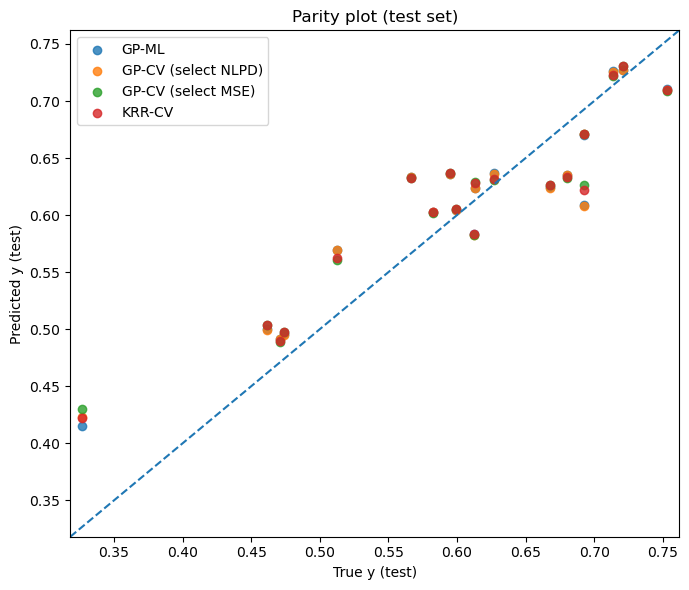

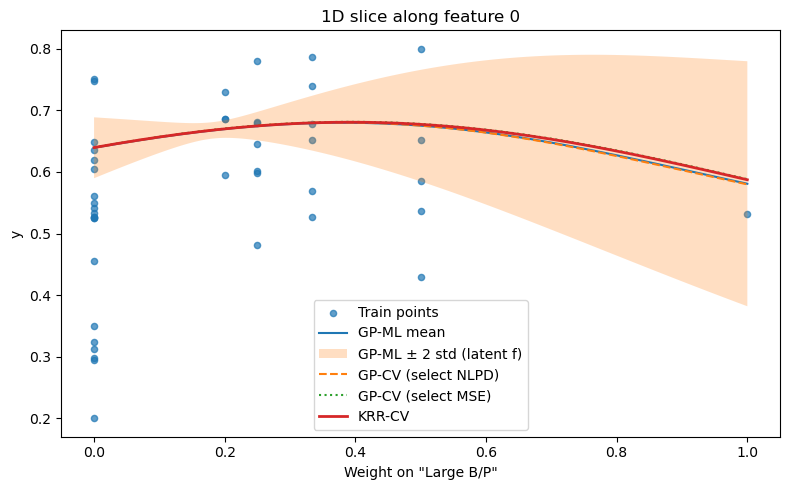

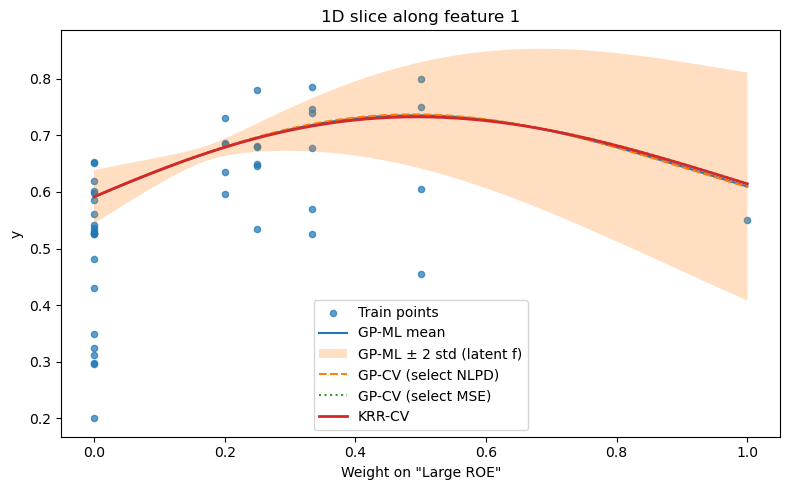

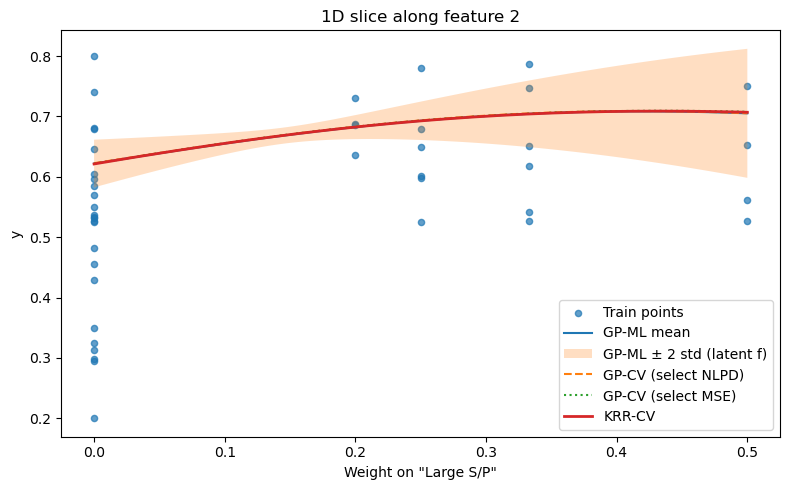

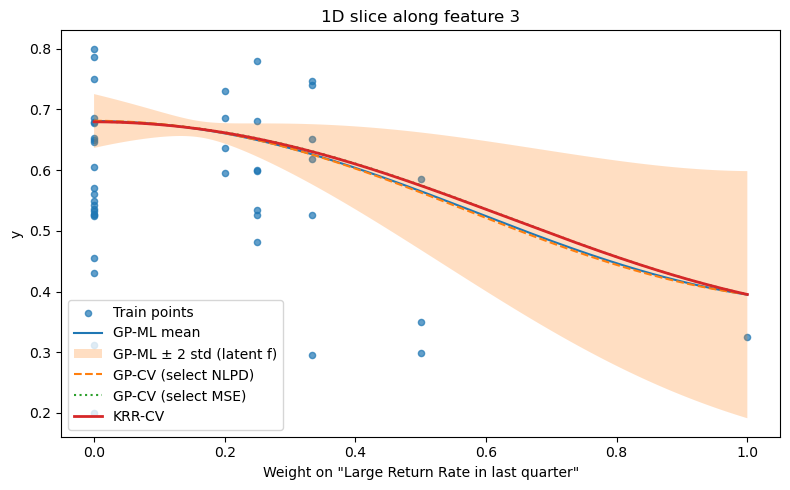

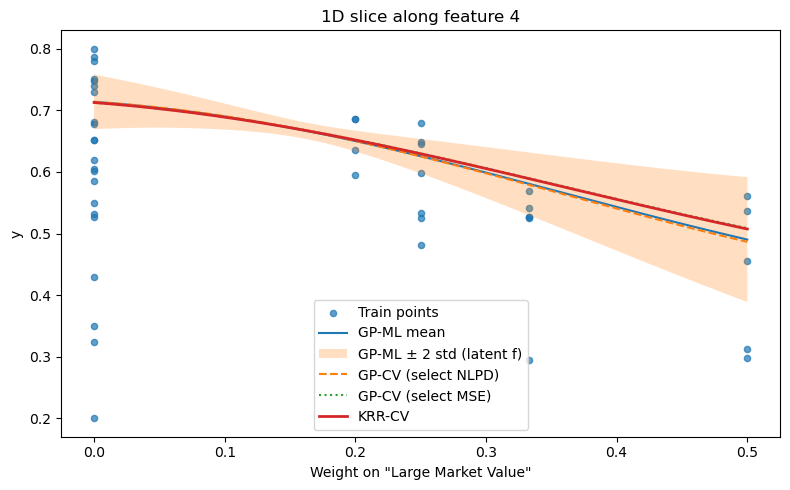

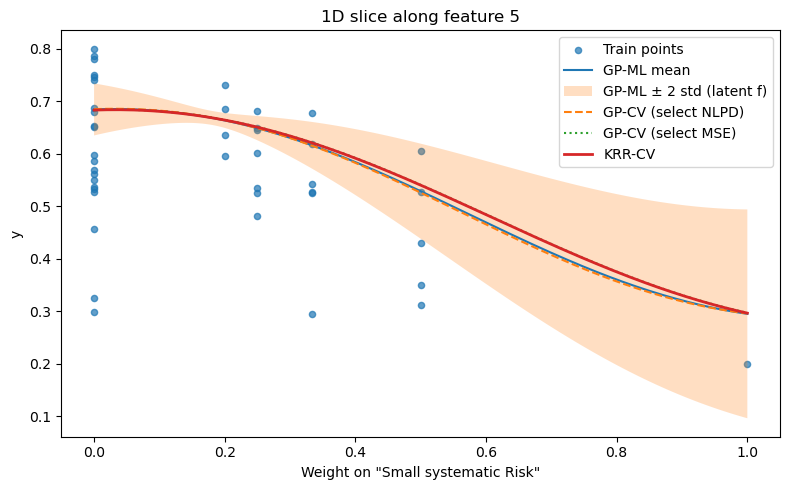

In [9]:
# Feature names in the same order as your 6 weight columns
feature_names = [
    'Weight on "Large B/P"',
    'Weight on "Large ROE"',
    'Weight on "Large S/P"',
    'Weight on "Large Return Rate in last quarter"',
    'Weight on "Large Market Value"',
    'Weight on "Small systematic Risk"',
]

make_all_plots(results, feature_names=feature_names)